In [15]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq

In [16]:
# Observed data
x = [  1.4557,  3.1200,  2.2762,  1.7253,  1.6040,    1.4986,  1.5503,  1.5412,1.5871,  1.5805,    1.4554,    1.4667,    1.4259,    1.4568,    1.4722,    1.4985,    1.5788,    1.5901,    1.5372,    1.5805,    1.5054,    1.5012,    1.4464,    1.5790,    1.6125,    1.5469]
y = [ 0.2383,    1.9637,    2.0233,    1.5525,    0.8493,    0.4720,    0.3195,    0.2758,    0.2557,    0.2447,    0.2605,    0.2719,    0.2513,    0.3371,    0.2646,    0.2475,    0.2593,    0.2556,    0.2450,    0.2256,    0.2489,    0.2612, 0.2591,    0.2959,    0.3152,    0.2526]
ode_data = transpose(hcat(x,y))
u0 = [x[1],y[1]]
tspan = (0.0f0, 1.5f0)
t = range(tspan[1], tspan[2], length = length(x))
species1 = "EGF50_ppMEK"
species2 = "EGF50_ppERK";

In [17]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

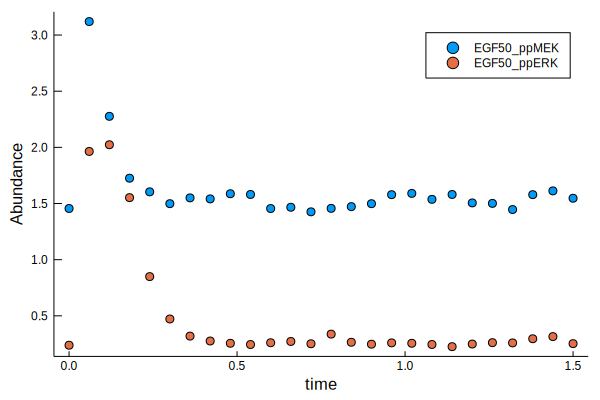

In [18]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1)
scatter!(t, ode_data[2,:], label = species2)

In [24]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(2,100,tanh),
       Dense(100,500,tanh),
       Dense(500,500,tanh),
       Dense(500,100,tanh),
       Dense(100,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
# Rosenbrock23, TRBDF2, ABDF2, Rodas5, Rodas4P, Kvaerno5, KenCarp4, CVODE_BDF (not defined)
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Rosenbrock23(autodiff=false), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff=false), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 20000
verify = 1000 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.00001)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end


#25 (generic function with 1 method)

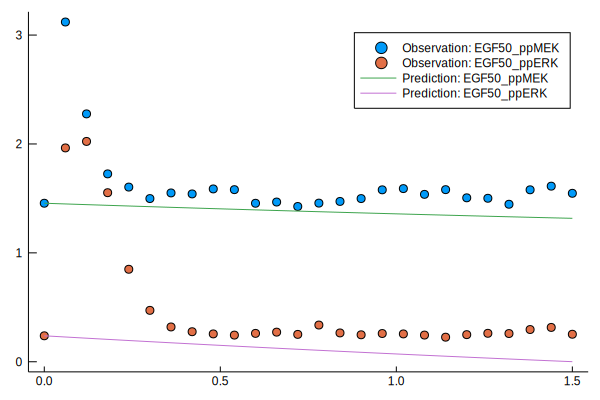

In [25]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [26]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)


2276.153159 seconds (413.03 M allocations: 1.219 TiB, 12.99% gc time)


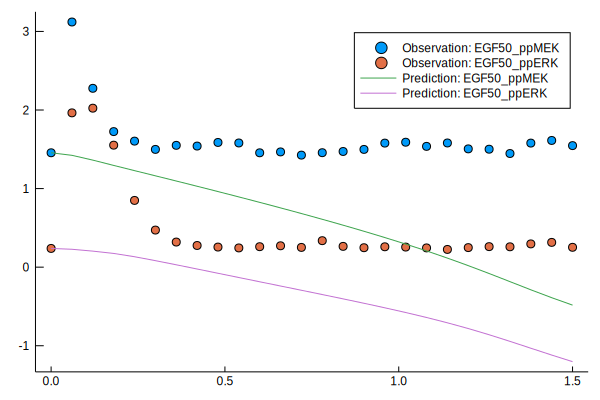

In [27]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))


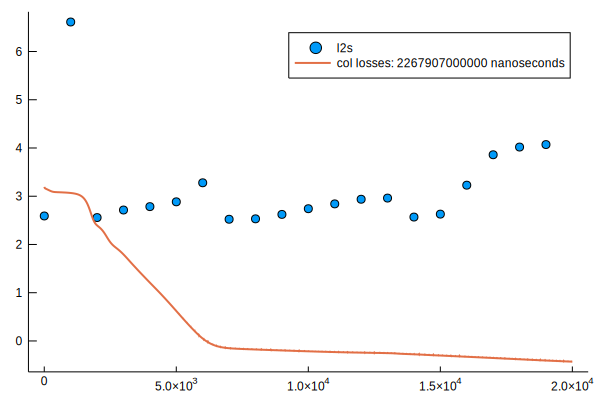

In [28]:
header = string("col losses: ", sa.times[end] - sa.times[1])
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "l2s", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s